In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [3]:
feature=pd.read_csv('feature.csv')
target=pd.read_csv('target.csv')

In [4]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8328 entries, 0 to 8327
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   total_retweet_count       8328 non-null   int64  
 1   total_favorite_count      8328 non-null   int64  
 2   total_hashtag_count       8328 non-null   int64  
 3   total_url_count           8328 non-null   int64  
 4   total_mentions_count      8328 non-null   int64  
 5   total_media_count         8328 non-null   int64  
 6   number_of_tweets_scraped  8328 non-null   float64
dtypes: float64(1), int64(6)
memory usage: 455.6 KB


In [5]:
targetSR=target['mbti_personality']

In [6]:
for row in target.index:
    # ie 구분
    if 'i' in target.loc[row,'mbti_personality']:
        target.loc[row,'ie']='i'
    else: target.loc[row,'ie']='e'

    # ns 구분
    if 'n' in target.loc[row,'mbti_personality']:
        target.loc[row,'ns']='n'
    else: target.loc[row,'ns']='s'

    # ft 구분
    if 'f' in target.loc[row,'mbti_personality']:
        target.loc[row,'ft']='f'
    else: target.loc[row,'ft']='t'

    # jp구분
    if 'j' in target.loc[row,'mbti_personality']:
        target.loc[row,'jp']='j'
    else: target.loc[row,'jp']='p'

In [7]:
#target.to_csv('target_2.csv',index=False)

## 데이터 확인

In [8]:
target_ie=target['ie']
target_ns=target['ns']
target_ft=target['ft']
target_jp=target['jp']

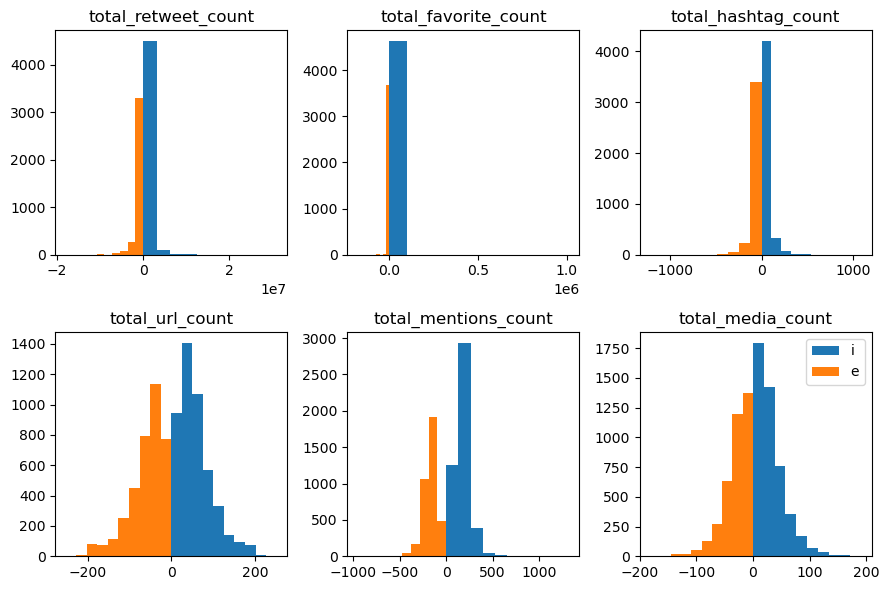

In [9]:
i_feature=feature[target_ie=='i']
e_feature=feature[target_ie=='e']
fig,ax=plt.subplots(figsize=(9,6),ncols=3,nrows=2)
for i in range(6):
    ax[i//3,i%3].hist(i_feature[feature.columns[i]],label='i')
    ax[i//3,i%3].hist(-e_feature[feature.columns[i]],label='e')
    ax[i//3,i%3].set(title=feature.columns[i])
plt.tight_layout()
plt.legend()

## 데이터셋 분리

In [11]:
from sklearn.model_selection import train_test_split, cross_validate

In [12]:
X_train,X_test,y_train,y_test=train_test_split(feature,target_ie,stratify=target_ie,random_state=38)

In [13]:
y_train.value_counts()

ie
0    3477
1    2769
Name: count, dtype: int64

## 학습

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
model=RandomForestClassifier(random_state=38)

In [16]:
model.fit(X_train,y_train)
print(f'train score : {model.score(X_train,y_train)}')
print(f'test score : {model.score(X_test,y_test)}')

train score : 1.0
test score : 0.5485110470701249


## 튜닝

In [113]:
from sklearn.model_selection import RandomizedSearchCV

# RandomForestClassfier 하이퍼 파라미터 설정
params={'max_depth':range(3,9),'min_samples_leaf':range(140,180)}

searchCV=RandomizedSearchCV(model,
                            param_distributions=params,
                            verbose=4)

searchCV.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .max_depth=3, min_samples_leaf=141;, score=0.568 total time=   0.5s
[CV 2/5] END .max_depth=3, min_samples_leaf=141;, score=0.560 total time=   0.4s
[CV 3/5] END .max_depth=3, min_samples_leaf=141;, score=0.559 total time=   0.4s
[CV 4/5] END .max_depth=3, min_samples_leaf=141;, score=0.568 total time=   0.4s
[CV 5/5] END .max_depth=3, min_samples_leaf=141;, score=0.556 total time=   0.4s
[CV 1/5] END .max_depth=7, min_samples_leaf=166;, score=0.579 total time=   0.6s
[CV 2/5] END .max_depth=7, min_samples_leaf=166;, score=0.576 total time=   0.6s
[CV 3/5] END .max_depth=7, min_samples_leaf=166;, score=0.576 total time=   0.5s
[CV 4/5] END .max_depth=7, min_samples_leaf=166;, score=0.564 total time=   0.5s
[CV 5/5] END .max_depth=7, min_samples_leaf=166;, score=0.565 total time=   0.6s
[CV 1/5] END .max_depth=6, min_samples_leaf=179;, score=0.575 total time=   0.7s
[CV 2/5] END .max_depth=6, min_samples_leaf=179;

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=38),
                   param_distributions={'max_depth': range(3, 9),
                                        'min_samples_leaf': range(140, 180)},
                   verbose=4)

In [114]:
print(f'max depth {searchCV.best_estimator_.max_depth}')
print(f'min_samples_leaf {searchCV.best_estimator_.min_samples_leaf}')

max depth 7
min_samples_leaf 166


In [115]:
searchCV.best_estimator_.score(X_train,y_train)

0.5867755363432597

In [116]:
searchCV.best_estimator_.score(X_test,y_test)

0.569164265129683

## 성능지표

In [117]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix

pred=searchCV.best_estimator_.predict(X_test)
print(f'정확도 { accuracy_score(y_test,pred)} 정밀도 {precision_score(y_test,pred)} 재현율 {recall_score(y_test,pred)}')

정확도 0.569164265129683 정밀도 0.5590909090909091 재현율 0.13326110509209102


In [118]:
print(confusion_matrix(y_test,pred))

[[1062   97]
 [ 800  123]]


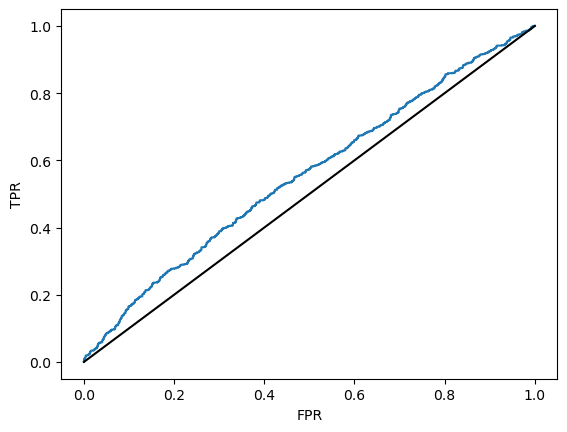

In [119]:
from sklearn.metrics import roc_curve
pred_proba=searchCV.best_estimator_.predict_proba(X_test)[:,1]

fprs,tprs,thresholds=roc_curve(y_test,pred_proba)
plt.plot(fprs,tprs,label='ROC')
plt.plot([0,1],[0,1],'k-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [120]:
searchCV.best_estimator_.feature_importances_

array([0.25737014, 0.18428027, 0.13123104, 0.10360824, 0.11627872,
       0.16478296, 0.04244863])